In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras

from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
from keras_unet_collection import layer_utils as k_layers
from keras_unet_collection.activations import GELU

2022-08-12 10:54:24.568133: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [4]:
flag_sparse = [0, 2, 3, 4, 10, 11, 12,]

In [5]:
filename_train_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*TRAIN*.npy"))
filename_train_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*TRAIN*.npy"))

filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))[::10]
filename_valid_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*VALID*.npy"))[::10]

In [6]:
grid_shape = (128, 128)

label_pos = np.ones(len(filename_valid_pos))
label_neg = np.zeros(len(filename_valid_neg))
VALID_label = np.hstack([label_pos, label_neg])

L_valid = len(VALID_label)
L_vars = 20
L_sparse = len(flag_sparse)
L_dense = L_vars - L_sparse

VALID_sparse = np.empty((L_valid,)+grid_shape+(L_sparse,))
VALID_dense = np.empty((L_valid,)+grid_shape+(L_dense,))
VALID_input = np.empty((L_valid,)+grid_shape+(L_vars,))

for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
    data = np.load(filename)
    count0 = 0
    count1 = 0
    VALID_input[i, ...] = data[...]
    
    for v in range(L_vars):
        if v in flag_sparse:
            VALID_sparse[i, ..., count0] = data[..., v]
            count0 += 1
        else:
            VALID_dense[i, ..., count1] = data[..., v]
            count1 += 1

In [7]:
IN = tf.keras.Input((128, 128, 20))

X = IN

X = k_layers.CONV_stack(X, 32, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack1')
X = tf.keras.layers.Conv2D(32, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv1')(X)

X = k_layers.CONV_stack(X, 64, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack2')
X = tf.keras.layers.Conv2D(64, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv2')(X)

X = k_layers.CONV_stack(X, 128, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack3')
X = tf.keras.layers.Conv2D(128, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv3')(X)

X = k_layers.CONV_stack(X, 256, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack4')
X = tf.keras.layers.Conv2D(256, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv4')(X)

X = k_layers.CONV_stack(X, 512, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack5')
X = tf.keras.layers.Conv2D(512, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv5')(X)

D = tf.keras.layers.Flatten()(X)

D = tf.keras.layers.Dense(512, use_bias=False, name='dense1')(D)
D = tf.keras.layers.BatchNormalization(axis=-1, name='dense_bn1')(D)
D = GELU()(D)

D = tf.keras.layers.Dense(128, use_bias=False, name='dense2')(D)
D = tf.keras.layers.BatchNormalization(axis=-1, name='dense_bn2')(D)
D = GELU()(D)

D = tf.keras.layers.Dense(1, activation='sigmoid', name='head')(D)
#D = tf.keras.layers.Softmax()(D)

OUT = D

2022-08-12 10:58:34.175301: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-12 10:58:34.218883: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-12 10:58:34.268257: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:62:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-12 10:58:34.268852: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-12 10:58:34.473603: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-12 10:58:34.474602: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [8]:
model = keras.models.Model(inputs=[IN,], outputs=[OUT,])
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=2e-5))

In [9]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100
batch_size_half = 50

valid_size = 1

In [10]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'VGG_tornado'

model_name = '{}_pp20'.format(key)
model_path = temp_dir+model_name

In [15]:
# X_batch_sparse = np.empty((batch_size, 128, 128, L_sparse))*np.nan
# X_batch_dense = np.empty((batch_size, 128, 128, L_dense))*np.nan
X_batch = np.empty((batch_size, 128, 128, L_vars))
Y_batch = np.empty((batch_size, 1))
X_batch[...] = np.nan
Y_batch[...] = np.nan

In [12]:
#Y_pred = model.predict([VALID_X])
record = 1.0 #np.nanmean(np.abs(Y_pred-VALID_Y))
print("Initial record: {}".format(record))

Initial record: 1.0


In [13]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
from sklearn.metrics import classification_report, auc, roc_curve

In [16]:
# ------------------- #
# loop of epoch
#filenames = glob(batch_dir+'TRAIN*.npy')

for i in range(epochs):
    #print('epoch = {}'.format(i))
    start_time = time.time()
    shuffle(filename_train_pos)
    shuffle(filename_train_neg)
    
    # loop of batch
    for j in range(L_train):
        
        shuffle(filename_train_pos)
        shuffle(filename_train_neg)
        
        file_pick_pos = filename_train_pos[:batch_size_half]
        file_pick_neg = filename_train_neg[:batch_size_half]
        
        file_pick = file_pick_pos+file_pick_neg
        
        for k in range(batch_size):
            data = np.load(file_pick[k])
            X_batch[k, ...] = data[...]
        
        # add noise within sparse inputs
        for v in flag_sparse:
            X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))
        
        # Soft labelling
        Y_batch[:batch_size_half, :] = np.random.uniform(0.95, 0.99, size=(batch_size_half, 1))
        Y_batch[batch_size_half:, :] = np.random.uniform(0.01, 0.05, size=(batch_size_half, 1))
        
        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([VALID_input,])
    
    fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
    record_temp = auc(fpr, tpr)
    record_temp = 1 - record_temp
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))


2022-08-12 11:03:47.941851: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-12 11:03:47.970015: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2022-08-12 11:03:48.976678: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-12 11:03:49.978074: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


Validation loss 0.16215968492885913 NOT improved
Validation loss 0.16496220238845605 NOT improved
Validation loss 0.19296820504416357 NOT improved
Validation loss improved from 1.0 to 0.1473651188345142
save to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20


2022-08-12 11:32:23.849155: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20/assets
--- 436.92192912101746 seconds ---
Validation loss improved from 0.1473651188345142 to 0.13087311379623345
save to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20/assets
--- 438.0288083553314 seconds ---
Validation loss improved from 0.13087311379623345 to 0.12248946068544153
save to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20/assets
--- 429.0602777004242 seconds ---
Validation loss improved from 0.12248946068544153 to 0.12070285908781486
save to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20/assets
--- 445.3712010383606 seconds ---
Validation loss improved from 0.12070285908781486 to 0.10423514726151162
save to: /gla

KeyboardInterrupt: 

In [24]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'VGG_tornado'

model_name = '{}_pp20'.format(key)
model_path = temp_dir+model_name

W = k_utils.dummy_loader(model_path)
model.set_weights(W)

model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.SGD(lr=2.5e-6))

model_name = '{}_pp20_tune'.format(key)
model_path = temp_dir+model_name

In [25]:
Y_pred = model.predict([VALID_input,])

fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
record_temp = auc(fpr, tpr)
record_temp = 1 - record_temp

print(record_temp)

0.10423514726151162


In [26]:
auc(fpr, tpr)

0.8957648527384884

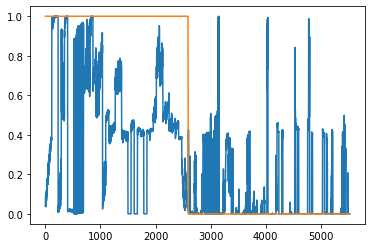

In [27]:
plt.plot(Y_pred.ravel())
plt.plot(VALID_label.ravel())

In [ ]:
# ------------------- #
# loop of epoch
#filenames = glob(batch_dir+'TRAIN*.npy')

for i in range(epochs):
    #print('epoch = {}'.format(i))
    start_time = time.time()
    shuffle(filename_train_pos)
    shuffle(filename_train_neg)
    
    # loop of batch
    for j in range(L_train):
        
        shuffle(filename_train_pos)
        shuffle(filename_train_neg)
        
        file_pick_pos = filename_train_pos[:batch_size_half]
        file_pick_neg = filename_train_neg[:batch_size_half]
        
        file_pick = file_pick_pos+file_pick_neg
        
        for k in range(batch_size):
            data = np.load(file_pick[k])
            X_batch[k, ...] = data[...]
        
        # add noise within sparse inputs
        for v in flag_sparse:
            X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))
        
        # Soft labelling
        Y_batch[:batch_size_half, :] = np.random.uniform(0.95, 0.99, size=(batch_size_half, 1))
        Y_batch[batch_size_half:, :] = np.random.uniform(0.01, 0.05, size=(batch_size_half, 1))
        
        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([VALID_input,])
    
    fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
    record_temp = auc(fpr, tpr)
    record_temp = 1 - record_temp
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

Validation loss improved from 0.10423514726151162 to 0.10333990957147299
save to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20_tune
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20_tune/assets
--- 426.8856997489929 seconds ---
Validation loss improved from 0.10333990957147299 to 0.10320518073099194
save to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20_tune
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20_tune/assets
--- 419.2100965976715 seconds ---
Validation loss 0.10328869685433106 NOT improved
Validation loss improved from 0.10320518073099194 to 0.10284800485759182
save to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20_tune
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/VGG_tornado_pp20_tune/assets
--- 415.4635727405548 seconds ---
Validation loss 0.10373923745052083 NOT improved
Validation loss 0.10341869836707596 NOT improved
Validation loss 0.10376648524233334 N

In [50]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'TH_chad'
model_name = '{}_pp20'.format(key)
model_path = temp_dir+model_name

W = k_utils.dummy_loader(model_path)
model.set_weights(W)

### Classification results

In [9]:
from sklearn.metrics import classification_report, auc, roc_curve

In [53]:
#filename_train_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*TRAIN*.npy"))
#filename_train_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*TRAIN*.npy"))

filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))
filename_valid_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*VALID*.npy"))

In [54]:
grid_shape = (128, 128)

label_pos = np.ones(len(filename_valid_pos))
label_neg = np.zeros(len(filename_valid_neg))
VALID_label = np.hstack([label_pos, label_neg])

L_valid = len(VALID_label)
L_vars = 20
L_sparse = len(flag_sparse)
L_dense = L_vars - L_sparse

VALID_sparse = np.empty((L_valid,)+grid_shape+(L_sparse,))
VALID_dense = np.empty((L_valid,)+grid_shape+(L_dense,))

for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
    data = np.load(filename)
    count0 = 0
    count1 = 0
    for v in range(L_vars):
        if v in flag_sparse:
            VALID_sparse[i, ..., count0] = data[..., v]
            count0 += 1
        else:
            VALID_dense[i, ..., count1] = data[..., v]
            count1 += 1

In [60]:
VALID_label

array([1., 1., 1., ..., 0., 0., 0.])

In [55]:
# filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))[::10]
# label_pos = np.ones(len(filename_valid_pos))
# label_neg = np.zeros(len(filename_valid_neg))
# VALID_label_skew = np.hstack([label_pos, label_neg])

# L_valid = len(VALID_label_skew)

# VALID_skew = np.empty((L_valid,)+grid_shape+(5,))

# for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
#     data = np.load(filename)
#     VALID_skew[i, ...] = data[...]

**Balanced verif**

In [56]:
Y_pred = model.predict([VALID_dense, VALID_sparse])
Y_pred_label = Y_pred > 0.5

2022-08-11 17:58:34.004253: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 47110422528 exceeds 10% of free system memory.


In [57]:
print(classification_report(Y_pred_label.ravel(), VALID_label.ravel()))

              precision    recall  f1-score   support

         0.0       1.00      0.53      0.69     55296
         1.0       0.00      0.00      0.00         0

    accuracy                           0.53     55296
   macro avg       0.50      0.27      0.35     55296
weighted avg       1.00      0.53      0.69     55296



/glade/work/ksha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/glade/work/ksha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/glade/work/ksha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
print(classification_report(Y_pred_label.ravel(), VALID_label.ravel()))

              precision    recall  f1-score   support

       False       0.88      0.78      0.83     33142
        True       0.72      0.84      0.77     22154

    accuracy                           0.80     55296
   macro avg       0.80      0.81      0.80     55296
weighted avg       0.81      0.80      0.80     55296



In [58]:
fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.9319409017491813

In [17]:
fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.8871815021742365

In [18]:
fpr.shape

(17970,)

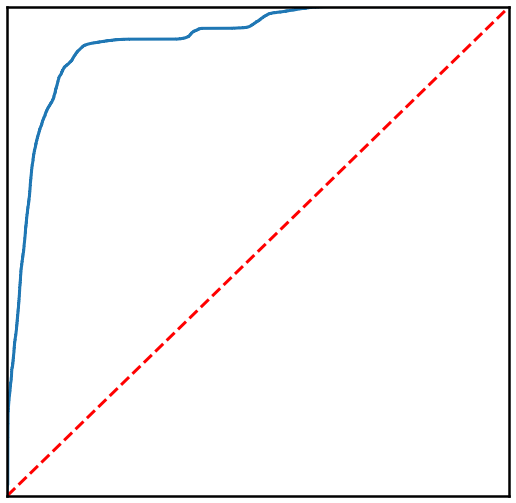

In [61]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
ax = gu.ax_decorate_box(ax)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(fpr, tpr, lw=3)
ax.plot(fpr, fpr, 'r--', lw=3)

**Natural verif**

In [25]:
Y_pred = model.predict([VALID_skew])
Y_pred_label = Y_pred > 0.5
print(classification_report(Y_pred_label.ravel(), VALID_label_skew.ravel()))

              precision    recall  f1-score   support

       False       0.88      0.97      0.92     26640
        True       0.67      0.33      0.44      5328

    accuracy                           0.86     31968
   macro avg       0.78      0.65      0.68     31968
weighted avg       0.84      0.86      0.84     31968



In [26]:
fpr, tpr, thresholds = roc_curve(VALID_label_skew.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.8685229089653266

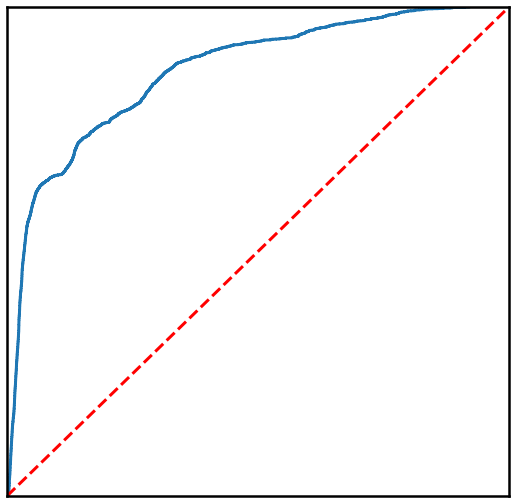

In [27]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
ax = gu.ax_decorate_box(ax)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(fpr, tpr, lw=3)
ax.plot(fpr, fpr, 'r--', lw=3)

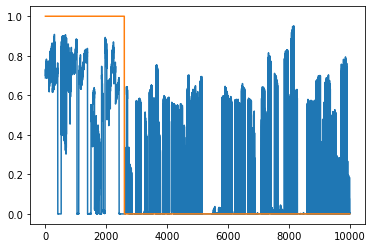

In [40]:
plt.plot(Y_pred.ravel()[:10000])
plt.plot(VALID_label_skew.ravel()[:10000])

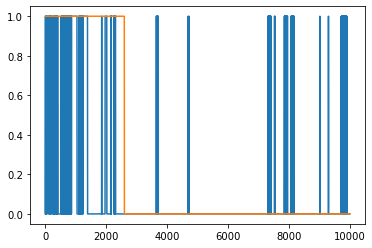

In [42]:
plt.plot(Y_pred.ravel()[:10000]>0.7)
plt.plot(VALID_label_skew.ravel()[:10000])